# Part 1 - Setting up Dependencies

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=ae367c2afd1cd3561799ea7e0d92f66b0b17a05f189994ae95be15482ffe8ba7
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
import re
import pandas as pd

## Basic Regular Expressions

In [ ]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<re.Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<re.Match object; span=(25, 36), match=' in PySpark'> 25 36


# Part 2 - Loading and Viewing the NASA Log Dataset



In [ ]:
import glob

raw_data_files = glob.glob('*.gz')
raw_data_files

['NASA_access_log_Jul95.gz']

### Taking a look at the metadata of our dataframe

In [ ]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [ ]:
type(base_df)

pyspark.sql.dataframe.DataFrame

You can also convert a dataframe to an RDD if needed

In [ ]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

### Viewing sample data in our dataframe
Looks like it needs to be wrangled and parsed!

In [ ]:
base_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

Getting data from an RDD is slightly different. You can see how the data representation is different in the following RDD

In [ ]:
base_df_rdd.take(10)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

# Part 3 - Data Wrangling




## Data Parsing and Extraction with Regular Expressions


In [ ]:
print((base_df.count(), len(base_df.columns)))

(1891715, 1)


Let's extract and take a look at some sample log messages

In [ ]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

### Extracting host names


In [ ]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

### Extracting timestamps 

Let's now try and use regular expressions to extract the timestamp fields from the logs

In [ ]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:15 -0400',
 '01/Jul/1995:00:00:15 -0400']

In [ ]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/history/apollo/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/KSC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0')]

### Extracting HTTP Status Codes



In [ ]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


### Extracting HTTP Response Content Size



In [ ]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074', '40310', '786', '1204', '40310', '786']


## Putting it all together 



In [ ]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

## Finding Missing Values

Missing and null values are the bane of data analysis and machine learning. Let's see how well our data parsing and extraction logic worked. First, let's verify that there are no null rows in the original dataframe.

In [ ]:
(base_df
    .filter(base_df['value']
                .isNull())
    .count())

0

If our data parsing and extraction worked properly, we should not have any rows with potential null values. Let's try and put that to test!

In [ ]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

19727

In [ ]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       19727|
+----+---------+------+--------+--------+------+------------+



### Handling nulls in HTTP status



In [ ]:
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

1

In [ ]:
null_status_df.show(truncate=False)

+--------+
|value   |
+--------+
|alyssa.p|
+--------+



In [ ]:
bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|    |         |      |        |        |null  |null        |
+----+---------+------+--------+--------+------+------------+



Looks like the record itself is an incomplete record with no useful information, the best option would be to drop this record as follows!

In [ ]:
logs_df.count()

1891715

In [ ]:
logs_df = logs_df[logs_df['status'].isNotNull()] 
logs_df.count()

1891714

In [ ]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       19726|
+----+---------+------+--------+--------+------+------------+



### Handling nulls in HTTP content size

Based on our previous regular expression, our original parsing regular expression for the `content_size` column was:

__```
regexp_extract('value', r'\s(\d+)$', 1).cast('integer').alias('content_size')
```__ 

Could there be missing data in our original dataset itself? Let's try and find out!

### Find out the records in our base data frame with potential missing content sizes

In [ ]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

19727

### Display the top ten records of your data frame having missing content sizes

In [ ]:
null_content_size_df.take(10)

[Row(value='dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -'),
 Row(value='dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:03:24 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='link097.txdirect.net - - [01/Jul/1995:00:05:06 -0400] "GET /shuttle HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:13 -0400] "GET /shuttle/missions/sts-78/news HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:58 -0400] "GET /shuttle/missions/sts-72/news HTTP/1.0" 302 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:19 -0400] "GET /pub/winvn/readme.txt HTTP/1.0" 404 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:28 -0400] "GET

In [ ]:
logs_df = logs_df.na.fill({'content_size': 0})

Now assuming everything we have done so far worked, we should have no missing values \ nulls in our dataset. Let's verify this!

In [ ]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



Look at that, no missing values! 

## Handling Temporal Fields (Timestamp)


In [ ]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [ ]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400']

In [ ]:
[parse_clf_time(item) for item in sample_ts]

['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

In [ ]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [ ]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [ ]:
logs_df.limit(5).toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,host,method,endpoint,protocol,status,content_size,time
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11


Let's now cache `logs_df` since we will be using it extensively for our data analysis section in the next part!

In [ ]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

# Part 4 - Data Analysis on our Web Logs


In [ ]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,1891714
1,mean,20455.509390425825
2,stddev,76957.4154501099
3,min,0
4,max,6823936


Alternatively, we can use SQL to directly calculate these statistics.  You can explore many useful functions within the `pyspark.sql.functions` module in the [documentation](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions).

After we apply the `.agg()` function, we call `toPandas()` to extract and convert the result into a `pandas` dataframe which has better formatting on Jupyter notebooks

In [ ]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,20455.50939,76957.41545,1891714


## HTTP Status Code Analysis

Next, let's look at the status code values that appear in the log. We want to know which status code values appear in the data and how many times.  

We again start with `logs_df`, then group by the `status` column, apply the `.count()` aggregation function, and sort by the `status` column.

In [ ]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

In [ ]:
print('Total distinct HTTP Status Codes:', status_freq_df.count())

Total distinct HTTP Status Codes: 8


In [ ]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,1701536
2,304,132627
1,302,46573
5,404,10843
6,500,62
4,403,54
7,501,14
3,400,5


In [ ]:
!pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


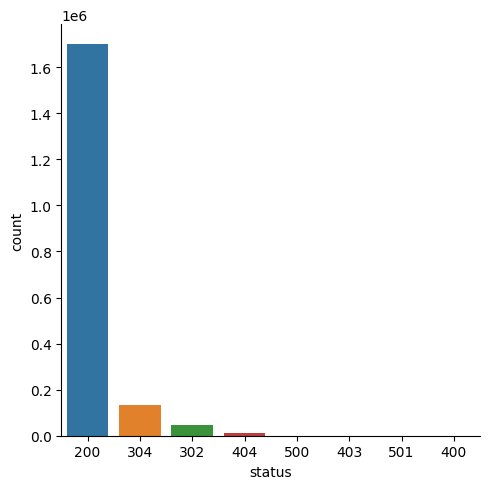

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [ ]:
log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   200|1701536|14.347041930501213|
|   302|  46573| 10.74877625305556|
|   304| 132627|11.795295955915682|
|   400|      5|1.6094379124341003|
|   403|     54|3.9889840465642745|
|   404|  10843| 9.291274989472182|
|   500|     62| 4.127134385045092|
|   501|     14|2.6390573296152584|
+------+-------+------------------+



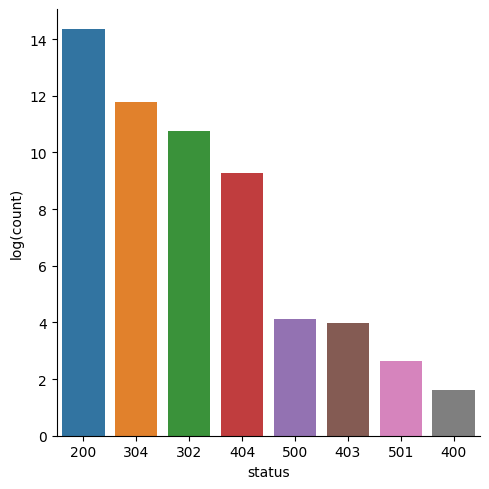

In [ ]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

## Analyzing Frequent Hosts

Let's look at hosts that have accessed the server frequently. We will try to get the count of total accesses by each `host` and then sort by the counts and display only the top ten most frequent hosts.

In [ ]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|17572|
|piweba4y.prodigy.com|11591|
|piweba1y.prodigy.com|9868 |
|alyssa.prodigy.com  |7852 |
|siltb10.orl.mmc.com |7573 |
|piweba2y.prodigy.com|5922 |
|edams.ksc.nasa.gov  |5434 |
|163.206.89.4        |4906 |
|news.ti.com         |4863 |
|                    |4796 |
+--------------------+-----+



In [ ]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[8]['host']

'news.ti.com'

Looks like we have some empty strings as one of the top host names! This teaches us a valuable lesson to not just check for nulls but also potentially empty strings when data wrangling.

## Display the Top 20 Frequent EndPoints

Now, let's visualize the number of hits to endpoints (URIs) in the log. To perform this task, we start with our `logs_df` and group by the `endpoint` column, aggregate by count, and sort in descending order like the previous question.

In [ ]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

In [ ]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/images/NASA-logosmall.gif,111330
1,/images/KSC-logosmall.gif,89638
2,/images/MOSAIC-logosmall.gif,60467
3,/images/USA-logosmall.gif,60013
4,/images/WORLD-logosmall.gif,59488
5,/images/ksclogo-medium.gif,58801
6,/images/launch-logo.gif,40871
7,/shuttle/countdown/,40278
8,/ksc.html,40226
9,/images/ksclogosmall.gif,33585


## Top Ten Error Endpoints

What are the top ten endpoints requested which did not have return code 200 (HTTP Status OK)? 

We create a sorted list containing the endpoints and the number of times that they were accessed with a non-200 return code and show the top ten.

In [ ]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

In [ ]:
error_endpoints_freq_df.show(truncate=False)

+--------------------------------------+-----+
|endpoint                              |count|
+--------------------------------------+-----+
|/images/NASA-logosmall.gif            |21010|
|/images/KSC-logosmall.gif             |12435|
|/images/MOSAIC-logosmall.gif          |6628 |
|/images/USA-logosmall.gif             |6577 |
|/images/WORLD-logosmall.gif           |6413 |
|/images/ksclogo-medium.gif            |5837 |
|/images/launch-logo.gif               |4628 |
|/shuttle/countdown/liftoff.html       |3509 |
|/shuttle/countdown/                   |3345 |
|/shuttle/countdown/images/cdtclock.gif|3251 |
+--------------------------------------+-----+



## Total number of Unique Hosts

What were the total number of unique hosts who visited the NASA website in these two months? We can find this out with a few transformations.

In [ ]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

81961

## Number of Unique Daily Hosts


In [ ]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |1  |
|unicomp6.unicomp.net|1  |
|199.120.110.21      |1  |
|burger.letters.com  |1  |
|199.120.110.21      |1  |
+--------------------+---+
only showing top 5 rows



**`host_day_distinct_df`**

This DataFrame has the same columns as `host_day_df`, but with duplicate (`day`, `host`) rows removed.

In [ ]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+-----------------------+---+
|host                   |day|
+-----------------------+---+
|129.94.144.152         |1  |
|slip1.yab.com          |1  |
|205.184.190.47         |1  |
|204.120.34.71          |1  |
|ppp3_130.bekkoame.or.jp|1  |
+-----------------------+---+
only showing top 5 rows



In [ ]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,1,5191
1,2,4858
2,3,7332
3,4,5523
4,5,7379
5,6,7815
6,7,6471
7,8,2898
8,9,2554
9,10,4460


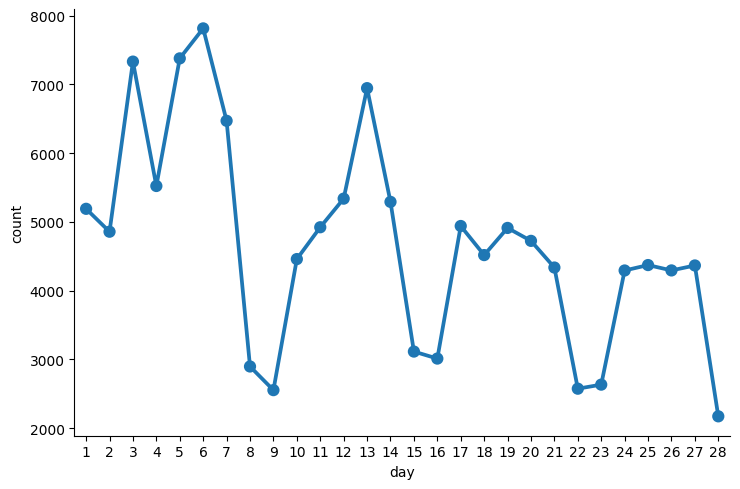

In [ ]:
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)

## Average Number of Daily Requests per Host

In the previous example, we looked at a way to determine the number of unique hosts in the entire log on a day-by-day basis. Let's now try and find the average number of requests being made per Host to the NASA website per day based on our logs. 

We'd like a DataFrame sorted by increasing day of the month which includes the day of the month and the associated number of average requests made for that day per Host. 

In [ ]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,64714,5191,12.466577
1,2,60265,4858,12.405311
2,3,89584,7332,12.218221
3,4,70452,5523,12.756111
4,5,94575,7379,12.816777
5,6,100960,7815,12.918746
6,7,87233,6471,13.480606
7,8,38867,2898,13.411663
8,9,35272,2554,13.810493
9,10,72860,4460,16.336323


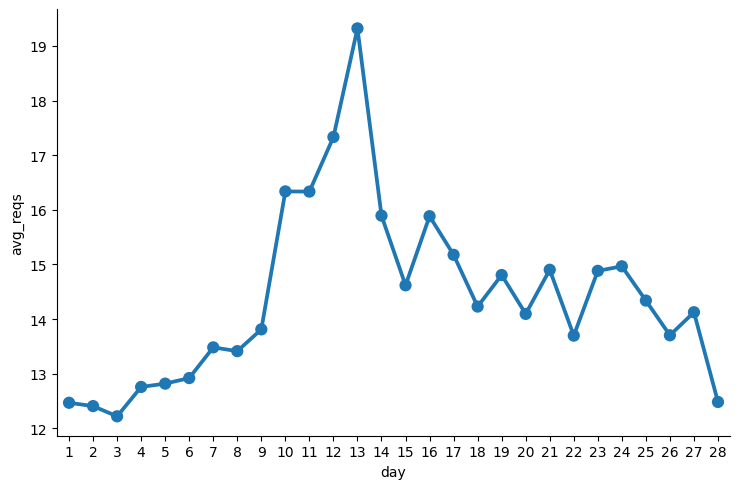

In [ ]:
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

## Counting 404 Response Codes

Create a DataFrame containing only log records with a 404 status code (Not Found). 

We make sure to `cache()` the `not_found_df` dataframe as we will use it in the rest of the examples here.

__How many 404 records are in the log?__

In [ ]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 10843


## Listing the Top Twenty 404 Response Code Endpoints

Using the DataFrame containing only log records with a 404 response code that we cached earlier, we will now print out a list of the top twenty endpoints that generate the most 404 errors.

*Remember, top endpoints should be in sorted order*

In [ ]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |667  |
|/pub/winvn/release.txt                                           |547  |
|/history/apollo/apollo-13.html                                   |286  |
|/shuttle/resources/orbiters/atlantis.gif                         |232  |
|/history/apollo/a-001/a-001-patch-small.gif                      |230  |
|/://spacelink.msfc.nasa.gov                                      |215  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|215  |
|/images/crawlerway-logo.gif                                      |214  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |183  |
|/shuttle/resources/orbiters/discovery.gif                        |180  |
|/shuttle/missions/sts-68/ksc-upclose.

## Listing the Top Twenty 404 Response Code Hosts

Using the DataFrame containing only log records with a 404 response code that we cached earlier, we will now print out a list of the top twenty hosts that generate the most 404 errors.

*Remember, top hosts should be in sorted order*

In [ ]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|jbiagioni.npt.nuwc.navy.mil|131  |
|piweba3y.prodigy.com       |110  |
|piweba1y.prodigy.com       |92   |
|                           |84   |
|phaelon.ksc.nasa.gov       |64   |
|www-d4.proxy.aol.com       |61   |
|monarch.eng.buffalo.edu    |56   |
|piweba4y.prodigy.com       |56   |
|alyssa.prodigy.com         |54   |
|www-a2.proxy.aol.com       |52   |
|www-b4.proxy.aol.com       |48   |
|www-b6.proxy.aol.com       |44   |
|www-b3.proxy.aol.com       |43   |
|tearnest2.stpaul.ncr.com   |42   |
|www-d1.proxy.aol.com       |41   |
|www-b2.proxy.aol.com       |41   |
|www-d3.proxy.aol.com       |38   |
|piweba2y.prodigy.com       |38   |
|www-a1.proxy.aol.com       |38   |
+---------------------------+-----+



## Visualizing 404 Errors per Day

Let's explore our 404 records temporally (by time) now. Similar to the example showing the number of unique daily hosts, we will break down the 404 requests by day and get the daily counts sorted by day in `errors_by_date_sorted_df`.

In [ ]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,316
1,2,291
2,3,474
3,4,359
4,5,497
5,6,640
6,7,570
7,8,300
8,9,348
9,10,398


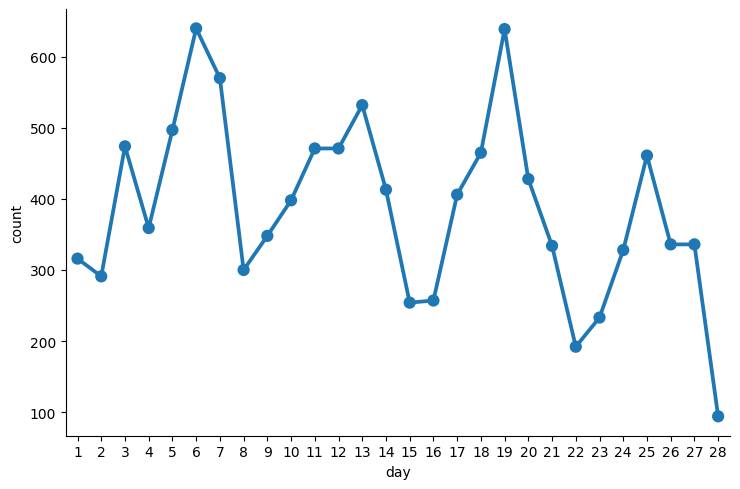

In [ ]:
c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

## Top Three Days for 404 Errors

What are the top three days of the month having the most 404 errors, we can leverage our previously created __`errors_by_date_sorted_df`__ for this. 

In [ ]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
|  6|  640|
| 19|  639|
|  7|  570|
+---+-----+
only showing top 3 rows



## Visualizing Hourly 404 Errors

Using the DataFrame `not_found_df` we cached earlier, we will now group and sort by hour of the day in increasing order, to create a DataFrame containing the total number of 404 responses for HTTP requests for each hour of the day (midnight starts at 0)

In [ ]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

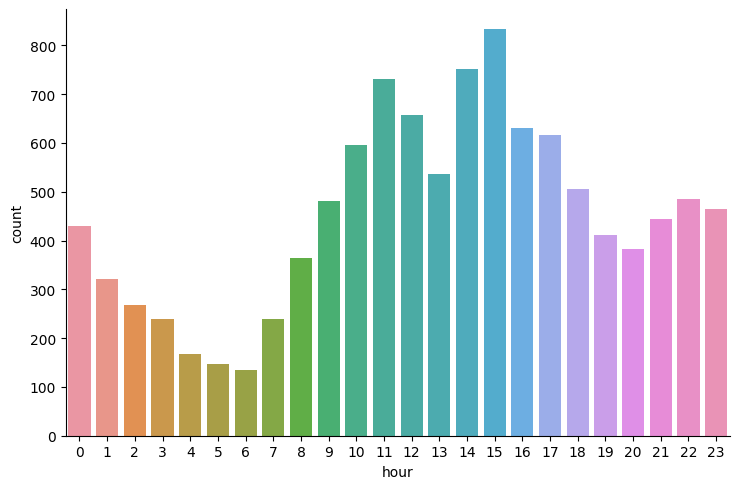

In [ ]:
c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)

### 3.1 Generate the output presenting the endpoint that received the highest number of invocations on a specific day of the week, along with the corresponding count of invocations. (Summarize this for the entire dataset)







In [ ]:
from pyspark.sql.functions import dayofweek, col, count, desc, first, max, lit, expr, when
from pyspark.sql.types import StringType
# Convert the 'timestamp' column to a timestamp type
logs_df = logs_df.withColumn('time', col('time').cast('timestamp'))

# Extract the day of the week from the timestamp
logs_df = logs_df.withColumn('day_of_week', dayofweek(col('time')))

In [ ]:
# Group the data by day of the week and endpoint, and count the invocations
grouped = logs_df.groupBy('day_of_week', 'endpoint').agg(count('*').alias('count'))

# Find the endpoint with the highest count for each day of the week
max_invocations = grouped.groupBy('day_of_week').agg(
    first('endpoint').alias('endpoint'),
    first('count').alias('count'),
    max('count').alias('max_count')
).orderBy(col('max_count').desc()).limit(1)

# Rename the columns and convert day_of_week to the actual day name
max_invocations = max_invocations.withColumn('day_of_week', expr("CASE day_of_week WHEN 1 THEN 'Sunday' WHEN 2 THEN 'Monday' WHEN 3 THEN 'Tuesday' WHEN 4 THEN 'Wednesday' WHEN 5 THEN 'Thursday' WHEN 6 THEN 'Friday' WHEN 7 THEN 'Saturday' END"))

# Define the desired output column names
columns = ["day_of_week", "endpoint", "count"]


# Display the output
max_invocations.select(columns).show(truncate=False)

+-----------+-------------------------------------------+-----+
|day_of_week|endpoint                                   |count|
+-----------+-------------------------------------------+-----+
|Thursday   |/shuttle/missions/sts-71/images/images.html|2503 |
+-----------+-------------------------------------------+-----+



# **3.1 Top 10 years in which there are least 404 status codes generated along with its count.**

In [ ]:
from pyspark.sql.functions import year, col, dense_rank
from pyspark.sql.window import Window


# Filter the DataFrame to include only 404 status codes
filtered_logs = logs_df.filter(col('status') == 404)

# Extract the year from the timestamp
filtered_logs = filtered_logs.withColumn('year', year(col('time')))

# Group the data by year and count the occurrences of 404 status codes
grouped_counts = filtered_logs.groupBy('year').count()

# Rank the years based on the count of 404 status codes in ascending order
window_spec = Window.orderBy(col('count').asc())
ranked_counts = grouped_counts.withColumn('rank', dense_rank().over(window_spec))

# Filter the top 10 years with the least count of 404 status codes
top_10_years = ranked_counts.filter(col('rank') <= 10).orderBy(col('count').asc())

# Display the output
top_10_years.show(truncate=False)

+----+-----+----+
|year|count|rank|
+----+-----+----+
|1995|10843|1   |
+----+-----+----+

